In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۴ — مبانی یادگیری نظارت‌شده
## درس ۱۳: مبانی یادگیری حساس به هزینه (آستانه‌گذاری، هزینه‌ها، مطلوبیت)

**جایگاه این درس در دوره.** در درس‌های قبلی فصل ۴، مبانی یادگیری نظارت‌شده، رگرسیون/طبقه‌بندی و معیارهای ارزیابی را مرور کردیم. این درس یک لایه «نظریه تصمیم» اضافه می‌کند: **مدل، خودِ تصمیم نیست**. مدل احتمال‌ها یا امتیازها را برآورد می‌کند؛ اما تصمیم باید با **هزینه/فایده**، **ریسک** و غالباً **قیود عملیاتی** اتخاذ شود.

**ایده کلیدی.** طبقه‌بندی‌کننده‌ای که *دقت (Accuracy)* را بیشینه می‌کند، ممکن است در عمل تصمیم بدی باشد؛ چون هزینهٔ انواع خطا یکسان نیست. یادگیری حساس به هزینه این هزینه‌ها را صریح می‌کند و هدف را بر همان اساس بهینه می‌سازد.

---

### آنچه در این درس یاد می‌گیرید
در پایان این درس، باید بتوانید:

1. یک مسئلهٔ واقعی را به یک **ماتریس هزینه** یا **مدل مطلوبیت** تبدیل کنید.
2. برای طبقه‌بندی دودویی و چندکلاسه، با داشتن احتمال‌های برآوردشده، **قاعدهٔ تصمیم بهینه** را استخراج و پیاده‌سازی کنید.
3. **تنظیم آستانه** (پس‌پردازش) را برای کمینه‌کردن هزینهٔ مورد انتظار یا بیشینه‌کردن مطلوبیت مورد انتظار انجام دهید.
4. تفاوت و ارتباط روش‌های زمان‌آموزش مانند **class_weight** و **sample_weight** را با آستانه‌گذاری درک کنید.
5. بفهمید چرا **کالیبراسیون احتمال** در تصمیم‌گیری حساس به هزینه مهم است.
6. یک گردش‌کار عملی و تکرارپذیر برای انتخاب مدل حساس به هزینه و گزارش‌دهی بسازید.

---

### چرا حساسیت به هزینه مطرح می‌شود؟
در بسیاری از کاربردها، مثبت کاذب و منفی کاذب هم‌وزن نیستند.

---

### نمادگذاری (دودویی)
- $y \\in \\{0,1\\}$ برچسب واقعی (۱ = مثبت، ۰ = منفی).
- $\\hat{y} \\in \\{0,1\\}$ برچسب پیش‌بینی‌شده.
- $p(x) = P(y=1\\mid x)$ احتمال برآوردشدهٔ کلاس مثبت.
- ماتریس هزینه $C$ با $C_{y,\\hat{y}}$.

---

### هزینهٔ مورد انتظار و آستانهٔ بهینه
اگر $C_{1,1}=C_{0,0}=0$ باشد، آستانهٔ بهینه برای پیش‌بینی مثبت:

$$p(x) \\ge \\frac{C_{FP}}{C_{FP}+C_{FN}}$$

---

### سه راهبرد عملی
1) آستانه‌گذاری + کالیبراسیون، 2) وزن‌دهی زمان‌آموزش، 3) روش‌های مستقیم حساس به هزینه.

---

### گردش‌کار پیشنهادی
تعریف تصمیم → تعریف هزینه/مطلوبیت → آموزش مدل احتمالی → تنظیم آستانه با CV → ارزیابی با هزینه/مطلوبیت → تحلیل حساسیت و مستندسازی.

In [2]:
# Common imports used throughout the lesson
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [3]:
# Utility helpers: thresholding, expected cost/utility, and plotting
def expected_cost_binary(y_true, y_proba_pos, threshold, cost_fp=1.0, cost_fn=5.0, cost_tp=0.0, cost_tn=0.0):
    # Costs:
    #   FP: predict 1 when y=0
    #   FN: predict 0 when y=1
    #   TP: predict 1 when y=1
    #   TN: predict 0 when y=0
    # Returns average cost per sample.
    y_pred = (y_proba_pos >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * cost_fp + fn * cost_fn + tp * cost_tp + tn * cost_tn
    return total_cost / (tn + fp + fn + tp)

def sweep_thresholds(y_true, y_proba_pos, thresholds, **cost_kwargs):
    costs = np.array([expected_cost_binary(y_true, y_proba_pos, t, **cost_kwargs) for t in thresholds])
    best_idx = int(np.argmin(costs))
    return costs, float(thresholds[best_idx]), float(costs[best_idx])

def plot_cost_curve(thresholds, costs, best_t=None, title="Expected cost vs threshold"):
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, costs)
    if best_t is not None:
        best_idx = int(np.argmin(costs))
        plt.scatter([best_t], [costs[best_idx]])
        plt.axvline(best_t, linestyle="--")
    plt.xlabel("Threshold (predict positive if p>=threshold)")
    plt.ylabel("Average expected cost")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_calibration(y_true, y_proba_pos, n_bins=10, title="Calibration curve"):
    frac_pos, mean_pred = calibration_curve(y_true, y_proba_pos, n_bins=n_bins, strategy="quantile")
    plt.figure(figsize=(5, 5))
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [4]:
# Helper: robust CSV loading with the repo's relative paths
from pathlib import Path

def load_csv(relative_path: str) -> pd.DataFrame:
    p = Path(relative_path)
    if not p.exists():
        raise FileNotFoundError(
            f"Could not find: {p.resolve()}\n"
            "Make sure you are running this notebook from the expected repo folder so the relative path works."
        )
    return pd.read_csv(p)

## بخش ۱ — آستانه‌گذاری حساس به هزینه برای `diabetes.csv`

در این بخش، رگرسیون لجستیک را آموزش می‌دهیم و سپس آستانهٔ عملیاتی را با یک مدل هزینهٔ نامتقارن انتخاب می‌کنیم.

مواردی که نشان می‌دهیم:
- پیمایش آستانه و منحنی هزینه
- ماتریس اغتشاش در آستانه‌های مختلف
- کالیبراسیون احتمال (sigmoid)
- انتخاب آستانه با پیش‌بینی خارج از فولد (CV)
- مقایسه با class_weight

به سلول‌های کد بعدی بروید.

In [5]:
# ===========================
# Part 1 — Binary cost-sensitive thresholding (diabetes.csv)
# ===========================

df_diabetes = load_csv("../../../Datasets/Classification/diabetes.csv")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [6]:
# Prepare features/target
target_col = "classification"
y = (df_diabetes[target_col] == "Diabetic").astype(int).values
X = df_diabetes.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

pipe_lr.fit(X_train, y_train)

proba_test = pipe_lr.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, proba_test))

ROC AUC: 0.832


In [7]:
# Define a business-like cost model (example)
# - False Negative (missed diabetic) is more expensive than False Positive
COST_FP = 1.0
COST_FN = 5.0
COST_TP = 0.0
COST_TN = 0.0

thresholds = np.linspace(0.01, 0.99, 99)
costs, best_t, best_cost = sweep_thresholds(
    y_test, proba_test, thresholds,
    cost_fp=COST_FP, cost_fn=COST_FN, cost_tp=COST_TP, cost_tn=COST_TN
)

best_t, best_cost

(0.16, 0.3541666666666667)

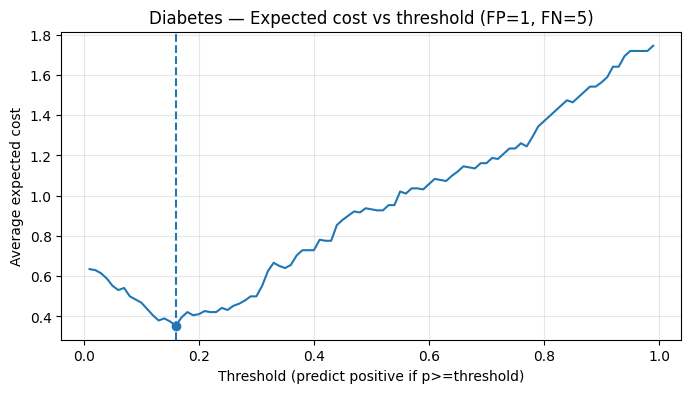

In [8]:
# Plot expected cost vs threshold
plot_cost_curve(thresholds, costs, best_t=best_t,
                title="Diabetes — Expected cost vs threshold (FP=1, FN=5)")

In [9]:
# Compare default threshold 0.50 vs cost-optimal threshold
def report_at_threshold(y_true, y_proba_pos, t, label):
    y_pred = (y_proba_pos >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    avg_cost = expected_cost_binary(
        y_true, y_proba_pos, t,
        cost_fp=COST_FP, cost_fn=COST_FN, cost_tp=COST_TP, cost_tn=COST_TN
    )
    print(f"--- {label} (threshold={t:.3f}) ---")
    print("Confusion matrix [ [TN FP] [FN TP] ]")
    print(np.array([[tn, fp],[fn, tp]]))
    print(f"Average expected cost: {avg_cost:.4f}")
    print(classification_report(y_true, y_pred, digits=3))

report_at_threshold(y_test, proba_test, 0.50, "Default")
report_at_threshold(y_test, proba_test, best_t, "Cost-optimal")

--- Default (threshold=0.500) ---
Confusion matrix [ [TN FP] [FN TP] ]
[[106  19]
 [ 32  35]]
Average expected cost: 0.9323
              precision    recall  f1-score   support

           0      0.768     0.848     0.806       125
           1      0.648     0.522     0.579        67

    accuracy                          0.734       192
   macro avg      0.708     0.685     0.692       192
weighted avg      0.726     0.734     0.727       192

--- Cost-optimal (threshold=0.160) ---
Confusion matrix [ [TN FP] [FN TP] ]
[[67 58]
 [ 2 65]]
Average expected cost: 0.3542
              precision    recall  f1-score   support

           0      0.971     0.536     0.691       125
           1      0.528     0.970     0.684        67

    accuracy                          0.688       192
   macro avg      0.750     0.753     0.687       192
weighted avg      0.817     0.688     0.688       192



ROC AUC (calibrated): 0.8315223880597016


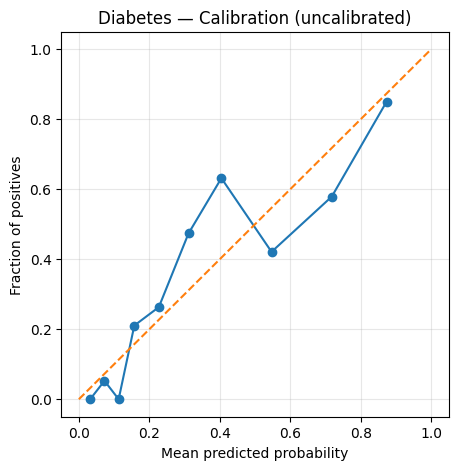

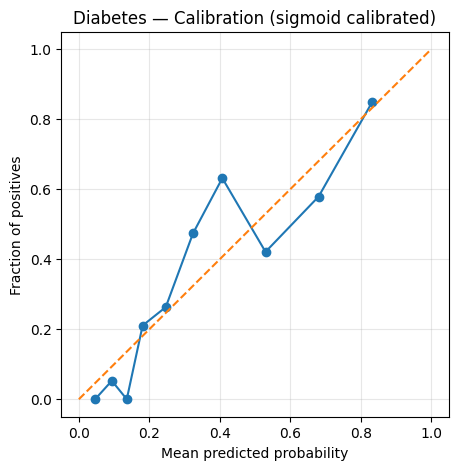

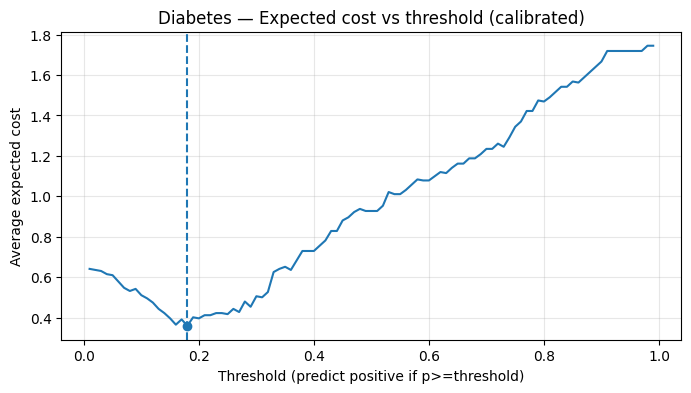

--- Cost-optimal (calibrated) (threshold=0.180) ---
Confusion matrix [ [TN FP] [FN TP] ]
[[66 59]
 [ 2 65]]
Average expected cost: 0.3594
              precision    recall  f1-score   support

           0      0.971     0.528     0.684       125
           1      0.524     0.970     0.681        67

    accuracy                          0.682       192
   macro avg      0.747     0.749     0.682       192
weighted avg      0.815     0.682     0.683       192



In [10]:
# Calibration matters: thresholding assumes probabilities are meaningful.
# Let's optionally calibrate the model and re-evaluate the cost curve.

calibrated = CalibratedClassifierCV(pipe_lr, method="sigmoid", cv=5)
calibrated.fit(X_train, y_train)
proba_test_cal = calibrated.predict_proba(X_test)[:, 1]

print("ROC AUC (calibrated):", roc_auc_score(y_test, proba_test_cal))

plot_calibration(y_test, proba_test, title="Diabetes — Calibration (uncalibrated)")
plot_calibration(y_test, proba_test_cal, title="Diabetes — Calibration (sigmoid calibrated)")

costs_cal, best_t_cal, best_cost_cal = sweep_thresholds(
    y_test, proba_test_cal, thresholds,
    cost_fp=COST_FP, cost_fn=COST_FN, cost_tp=COST_TP, cost_tn=COST_TN
)

plot_cost_curve(thresholds, costs_cal, best_t=best_t_cal,
                title="Diabetes — Expected cost vs threshold (calibrated)")

report_at_threshold(y_test, proba_test_cal, best_t_cal, "Cost-optimal (calibrated)")

In [11]:
# Cross-validated threshold selection (avoid tuning on test set)
# We estimate out-of-fold probabilities on the training set, pick threshold, then evaluate on test.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_proba = cross_val_predict(pipe_lr, X_train, y_train, cv=cv, method="predict_proba")[:, 1]

costs_oof, best_t_oof, best_cost_oof = sweep_thresholds(
    y_train, oof_proba, thresholds,
    cost_fp=COST_FP, cost_fn=COST_FN, cost_tp=COST_TP, cost_tn=COST_TN
)
print("Best threshold from CV (train OOF):", best_t_oof, "Avg cost:", best_cost_oof)

# Evaluate on test with that threshold
report_at_threshold(y_test, proba_test, best_t_oof, "Test with CV-selected threshold")

Best threshold from CV (train OOF): 0.13 Avg cost: 0.4704861111111111
--- Test with CV-selected threshold (threshold=0.130) ---
Confusion matrix [ [TN FP] [FN TP] ]
[[57 68]
 [ 1 66]]
Average expected cost: 0.3802
              precision    recall  f1-score   support

           0      0.983     0.456     0.623       125
           1      0.493     0.985     0.657        67

    accuracy                          0.641       192
   macro avg      0.738     0.721     0.640       192
weighted avg      0.812     0.641     0.635       192



Best threshold (class_weight model): 0.47000000000000003 Avg cost: 0.375


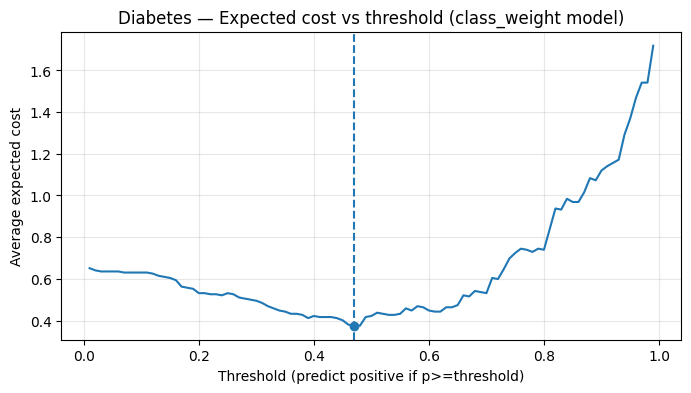

--- Cost-optimal (class_weight model) (threshold=0.470) ---
Confusion matrix [ [TN FP] [FN TP] ]
[[63 62]
 [ 2 65]]
Average expected cost: 0.3750
              precision    recall  f1-score   support

           0      0.969     0.504     0.663       125
           1      0.512     0.970     0.670        67

    accuracy                          0.667       192
   macro avg      0.741     0.737     0.667       192
weighted avg      0.810     0.667     0.666       192



In [12]:
# Training-time cost sensitivity via class_weight (not the same as thresholding, but often useful)
# We'll compare cost on the same test set.

pipe_lr_w = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight={0: 1.0, 1: 5.0}))
])
pipe_lr_w.fit(X_train, y_train)
proba_test_w = pipe_lr_w.predict_proba(X_test)[:, 1]

costs_w, best_t_w, best_cost_w = sweep_thresholds(
    y_test, proba_test_w, thresholds,
    cost_fp=COST_FP, cost_fn=COST_FN, cost_tp=COST_TP, cost_tn=COST_TN
)

print("Best threshold (class_weight model):", best_t_w, "Avg cost:", best_cost_w)
plot_cost_curve(thresholds, costs_w, best_t=best_t_w,
                title="Diabetes — Expected cost vs threshold (class_weight model)")
report_at_threshold(y_test, proba_test_w, best_t_w, "Cost-optimal (class_weight model)")

## بخش ۱.۱ — تفسیر نتایج: فراتر از Accuracy

هزینهٔ میانگین در آستانهٔ $t$:

$$\\text{AvgCost}(t) = \\frac{C_{FP}\\cdot FP(t) + C_{FN}\\cdot FN(t) + C_{TP}\\cdot TP(t) + C_{TN}\\cdot TN(t)}{n}$$

- AUC فقط رتبه‌بندی را می‌سنجد و آستانه انتخاب نمی‌کند.
- کالیبراسیون بررسی می‌کند آیا احتمال‌ها برای تصمیم‌گیری معتبرند یا نه.

در کد بالا، آستانهٔ پیش‌فرض 0.5 را با آستانهٔ بهینهٔ هزینه و آستانهٔ انتخاب‌شده با CV و همچنین حالت کالیبره‌شده مقایسه کنید.

## بخش ۲ — تصمیم حساس به هزینه برای چندکلاسه روی `drug200.csv`

قاعدهٔ تصمیم با ماتریس هزینه:

$$\\hat{y}(x) = \\arg\\min_{j} \\sum_{i=1}^K p_i(x)\\,C_{i,j}$$

در اینجا ممکن است Accuracy کمتر شود اما هزینهٔ تحقق‌یافته بهتر شود. همچنین گزینهٔ «ABSTAIN» برای بازبینی دستی را نشان می‌دهیم.

In [13]:
# ===========================
# Part 2 — Multi-class cost-sensitive decision rule (drug200.csv)
# ===========================

df_drug = load_csv("../../../Datasets/Classification/drug200.csv")
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [14]:
# Split features/target
target_col = "Drug"
y = df_drug[target_col].astype(str).values
X = df_drug.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Preprocess mixed types (categorical + numeric)
cat_cols = ["Sex", "BP", "Cholesterol"]
num_cols = ["Age", "Na_to_K"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols),
])

clf_mc = LogisticRegression(max_iter=3000, multi_class="auto")
pipe_mc = Pipeline([("prep", preprocess), ("clf", clf_mc)])
pipe_mc.fit(X_train, y_train)

proba = pipe_mc.predict_proba(X_test)  # shape: (n, K)
classes = pipe_mc.named_steps["clf"].classes_
classes

C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [15]:
# Define a (toy) cost matrix for demonstration.
# In practice, this must be informed by domain experts and safety/regulatory considerations.
#
# Cost matrix C[y_true, y_pred]. Diagonal is 0 (no penalty if correct).
# We'll assume some misclassifications are more costly than others.

K = len(classes)
C = np.ones((K, K), dtype=float)
np.fill_diagonal(C, 0.0)

# Example: make confusing DrugY particularly risky
if "DrugY" in classes:
    idxY = int(np.where(classes == "DrugY")[0][0])
    C[:, idxY] *= 4.0   # predicting DrugY wrongly
    C[idxY, :] *= 3.0   # missing true DrugY

# Example: slightly higher cost for confusing drugA with drugB (illustrative)
if "drugA" in classes and "drugB" in classes:
    ia = int(np.where(classes == "drugA")[0][0])
    ib = int(np.where(classes == "drugB")[0][0])
    C[ia, ib] = 2.5
    C[ib, ia] = 2.0

pd.DataFrame(C, index=classes, columns=classes)

,DrugY,drugA,drugB,drugC,drugX
DrugY,0.0,3.0,3.0,3.0,3.0
drugA,4.0,0.0,2.5,1.0,1.0
drugB,4.0,2.0,0.0,1.0,1.0
drugC,4.0,1.0,1.0,0.0,1.0
drugX,4.0,1.0,1.0,1.0,0.0


In [16]:
# Cost-sensitive prediction: choose y_pred that minimizes expected cost under predicted probabilities
def predict_min_expected_cost(proba, cost_matrix, classes):
    # For each candidate prediction j, expected cost = sum_y proba_y * C[y, j]
    exp_cost_by_pred = proba @ cost_matrix  # (n, K)
    j_star = np.argmin(exp_cost_by_pred, axis=1)
    return classes[j_star], exp_cost_by_pred

y_pred_acc = pipe_mc.predict(X_test)
y_pred_cost, exp_cost_by_pred = predict_min_expected_cost(proba, C, classes)

# Compare accuracy vs average expected cost
acc_default = float(np.mean(y_pred_acc == y_test))
acc_cost = float(np.mean(y_pred_cost == y_test))

# Expected cost realized on the test set under each decision rule
label_to_index = {c: i for i, c in enumerate(classes)}

def realized_avg_cost(y_true, y_pred, cost_matrix, label_to_index):
    idx_true = np.array([label_to_index[t] for t in y_true])
    idx_pred = np.array([label_to_index[p] for p in y_pred])
    return float(np.mean(cost_matrix[idx_true, idx_pred]))

cost_default = realized_avg_cost(y_test, y_pred_acc, C, label_to_index)
cost_cost = realized_avg_cost(y_test, y_pred_cost, C, label_to_index)

print("Default argmax accuracy:", acc_default)
print("Cost-minimizing accuracy:", acc_cost)
print("Default realized avg cost:", cost_default)
print("Cost-minimizing realized avg cost:", cost_cost)

Default argmax accuracy: 0.92
Cost-minimizing accuracy: 0.94
Default realized avg cost: 0.3
Cost-minimizing realized avg cost: 0.1


In [17]:
# Confusion matrices (rows: true, cols: predicted)
def confusion_df(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    return pd.DataFrame(cm, index=[f"true:{c}" for c in classes], columns=[f"pred:{c}" for c in classes])

conf_default = confusion_df(y_test, y_pred_acc, classes)
conf_cost = confusion_df(y_test, y_pred_cost, classes)

conf_default, conf_cost

(            pred:DrugY  pred:drugA  pred:drugB  pred:drugC  pred:drugX
 true:DrugY          22           0           0           0           1
 true:drugA           0           6           0           0           0
 true:drugB           2           0           2           0           0
 true:drugC           0           0           0           4           0
 true:drugX           1           0           0           0          12,
             pred:DrugY  pred:drugA  pred:drugB  pred:drugC  pred:drugX
 true:DrugY          22           0           0           0           1
 true:drugA           0           6           0           0           0
 true:drugB           0           0           2           2           0
 true:drugC           0           0           0           4           0
 true:drugX           0           0           0           0          13)

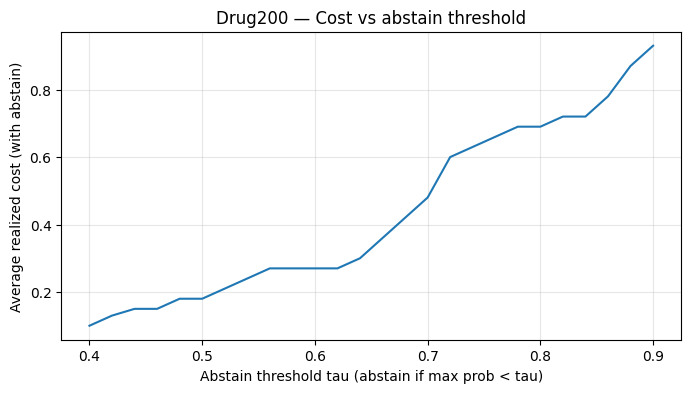

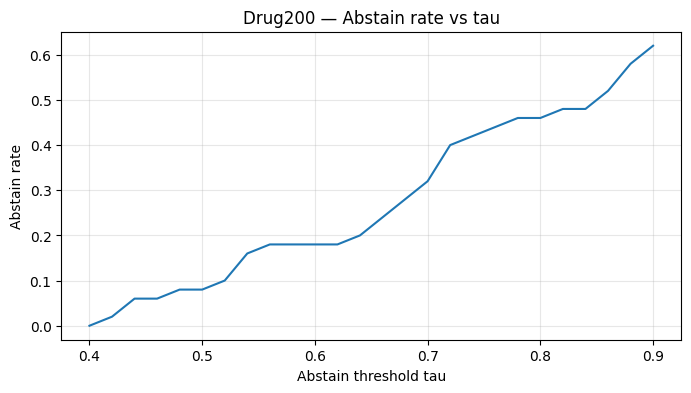

In [18]:
# Optional: add an abstain/reject option when model is uncertain.
# Rule: if max probability < tau -> "ABSTAIN"; otherwise pick min expected cost among classes.
# Cost of abstaining can be set to represent manual review or deferred decision.

def predict_with_abstain(proba, cost_matrix, classes, tau=0.55):
    exp_cost_by_pred = proba @ cost_matrix  # (n, K)
    pred_idx = np.argmin(exp_cost_by_pred, axis=1)
    preds = classes[pred_idx].astype(object)

    maxp = proba.max(axis=1)
    abstain = maxp < tau
    preds[abstain] = "ABSTAIN"
    return preds

def realized_avg_cost_with_abstain(y_true, y_pred, cost_matrix, label_to_index, cost_abstain=1.5):
    costs = []
    for t, p in zip(y_true, y_pred):
        if p == "ABSTAIN":
            costs.append(cost_abstain)
        else:
            costs.append(cost_matrix[label_to_index[t], label_to_index[p]])
    return float(np.mean(costs))

taus = np.linspace(0.40, 0.90, 26)
avg_costs = []
abstain_rates = []
for tau in taus:
    preds = predict_with_abstain(proba, C, classes, tau=tau)
    avg_costs.append(realized_avg_cost_with_abstain(y_test, preds, C, label_to_index, cost_abstain=1.5))
    abstain_rates.append(float(np.mean(preds == "ABSTAIN")))

plt.figure(figsize=(8, 4))
plt.plot(taus, avg_costs)
plt.xlabel("Abstain threshold tau (abstain if max prob < tau)")
plt.ylabel("Average realized cost (with abstain)")
plt.title("Drug200 — Cost vs abstain threshold")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(taus, abstain_rates)
plt.xlabel("Abstain threshold tau")
plt.ylabel("Abstain rate")
plt.title("Drug200 — Abstain rate vs tau")
plt.grid(True, alpha=0.3)
plt.show()

## بخش ۳ — چارچوب مطلوبیت روی `Wine_Quality.csv`

آستانه را طوری انتخاب کنید که مطلوبیت مورد انتظار بیشینه شود:

$$t^* = \\arg\\max_t \\; \\mathbb{E}[U(t)]$$

در کد، کیفیت را دودویی می‌کنیم ($\\text{quality} \\ge 7$) و یک تابع مطلوبیت نمایشی را بهینه می‌کنیم.

In [19]:
# ===========================
# Part 3 — Utility / profit framing (Wine_Quality.csv)
# ===========================

df_wine = load_csv("../../../Datasets/Classification/Wine_Quality.csv")
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [20]:
# Create a binary target: "high_quality" if quality >= 7 (you can change this cutoff)
y = (df_wine["quality"] >= 7).astype(int).values
X = df_wine.drop(columns=["quality"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])
pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:, 1]

print("Base rate (positive):", float(y_test.mean()))
print("ROC AUC:", roc_auc_score(y_test, proba))

Base rate (positive): 0.2163265306122449
ROC AUC: 0.7844064465408805


In [21]:
# Utility model (example):
# - If we predict "high quality" and it's truly high quality: +10
# - If we predict "high quality" and it's not: -3  (wasted promotion)
# - If we predict "not high quality" and it's truly high quality: -6  (missed opportunity)
# - If we predict "not high quality" and it's not: 0
U_TP = 10.0
U_FP = -3.0
U_FN = -6.0
U_TN = 0.0

def expected_utility_binary(y_true, y_proba_pos, threshold, U_tp, U_fp, U_fn, U_tn):
    y_pred = (y_proba_pos >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_u = tp * U_tp + fp * U_fp + fn * U_fn + tn * U_tn
    return total_u / (tn + fp + fn + tp)

thresholds = np.linspace(0.01, 0.99, 99)
utils = np.array([expected_utility_binary(y_test, proba, t, U_TP, U_FP, U_FN, U_TN) for t in thresholds])
best_idx = int(np.argmax(utils))
best_t_u = float(thresholds[best_idx])
best_u = float(utils[best_idx])

best_t_u, best_u

(0.2, 0.6595918367346939)

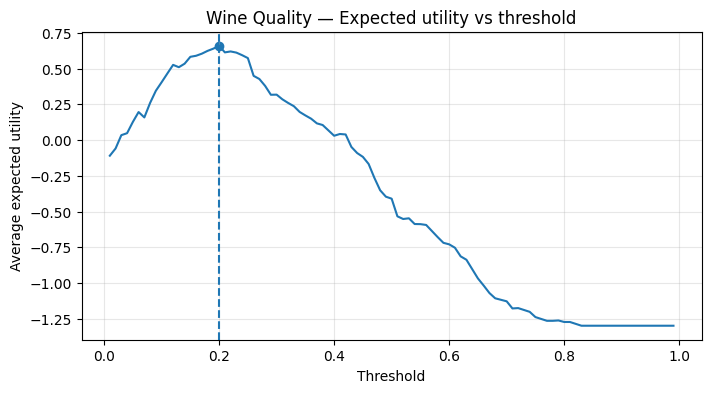

--- Utility-optimal (threshold=0.200) ---
Confusion matrix [ [TN FP] [FN TP] ]
[[650 310]
 [ 57 208]]
              precision    recall  f1-score   support

           0      0.919     0.677     0.780       960
           1      0.402     0.785     0.531       265

    accuracy                          0.700      1225
   macro avg      0.660     0.731     0.656      1225
weighted avg      0.807     0.700     0.726      1225



In [22]:
# Plot expected utility vs threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, utils)
plt.scatter([best_t_u], [best_u])
plt.axvline(best_t_u, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Average expected utility")
plt.title("Wine Quality — Expected utility vs threshold")
plt.grid(True, alpha=0.3)
plt.show()

# Reuse the report helper from Part 1 (it depends on COST_*; redefine cost terms as neutral here if needed)
COST_FP = 1.0
COST_FN = 1.0
COST_TP = 0.0
COST_TN = 0.0

def report_at_threshold(y_true, y_proba_pos, t, label):
    y_pred = (y_proba_pos >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"--- {label} (threshold={t:.3f}) ---")
    print("Confusion matrix [ [TN FP] [FN TP] ]")
    print(np.array([[tn, fp],[fn, tp]]))
    print(classification_report(y_true, y_pred, digits=3))

report_at_threshold(y_test, proba, best_t_u, "Utility-optimal")

## تعمق بیشتر: تحلیل تصمیم، گزارش‌دهی و تحلیل حساسیت

این بخش برای استفادهٔ مجدد به‌عنوان مرجع اضافه شده است.

### ۱) از ماتریس اغتشاش تا شاخص‌های تصمیم‌محور
می‌توان شمارش‌ها را به نرخ و سپس به هزینه/سود تبدیل کرد.

### ۲) انتخاب آستانه یک سیاست است
با تغییر نرخ پایه یا ظرفیت عملیاتی، آستانهٔ بهینه تغییر می‌کند. بنابراین آستانه و مفروضات آن باید نسخه‌بندی و مستندسازی شود.

### ۳) تحلیل حساسیت
هزینه‌ها را به‌صورت بازه در نظر بگیرید و پایداری آستانه را بررسی کنید. برای حالت ساده:
$$t^* = \\frac{C_{FP}}{C_{FP}+C_{FN}}$$

### ۴) کالیبراسیون
اگر از آستانهٔ احتمال استفاده می‌کنید، کالیبراسیون بسیار مهم است؛ وزن‌دهی زمان‌آموزش می‌تواند مقیاس احتمال‌ها را تغییر دهد.

### ۵) حاکمیت در ماتریس هزینهٔ چندکلاسه
در حوزه‌های حساس، ماتریس هزینه باید با ذی‌نفعان و با مستندسازی مناسب تعیین شود.

### ۶) گزینهٔ امتناع
اضافه‌کردن «بازبینی انسانی» یک عمل اضافی است و باید هزینهٔ آن در تصمیم لحاظ شود.

### ۷) قالب گزارش پیشنهادی
دیتاست/تقسیم‌بندی، نرخ‌های پایه، مدل و کالیبراسیون، مفروضات هزینه/مطلوبیت، روش انتخاب آستانه، هزینه/مطلوبیت تست، ماتریس اغتشاش، و تحلیل حساسیت.

### ۸) خطاهای رایج
تنظیم آستانه روی تست، نادیده‌گرفتن کالیبراسیون، و اتکای صرف به Accuracy.

این نگاه تصمیم‌محور به‌طور طبیعی به فصل‌های ارزیابی (فصل ۱۳)، انصاف/ریسک (فصل ۳۳) و MLOps (فصل ۳۴) متصل می‌شود.

In [23]:
# ===========================
# Exercises (write your solutions below)
# ===========================

# Exercise 1:
# Implement a function that returns BOTH the average expected cost and the confusion matrix for a given threshold.
# Then verify it matches expected_cost_binary and sklearn confusion_matrix outputs.
#
# def cost_and_cm(...):
#     ...
#
# Exercise 2:
# Using diabetes.csv, compare three strategies:
#   (A) train baseline model + tune threshold
#   (B) train with class_weight + tune threshold
#   (C) calibrate probabilities + tune threshold
# Report: ROC AUC, best threshold, and average cost on a held-out test set.
#
# Exercise 3:
# For the multiclass drug200 example, replace the toy cost matrix with:
#   - a symmetric matrix (same penalty for i->j and j->i)
#   - an asymmetric matrix
# Compare how predictions change and how realized cost changes.
#
# Exercise 4:
# Add an "ABSTAIN" option to diabetes as well:
#   - abstain if predicted probability is in an uncertainty band [0.45, 0.55]
#   - assign abstain cost = 0.7
# Sweep the band width and report cost and abstain rate.
#
# Exercise 5:
# For Wine_Quality, try different definitions of "high quality" (>=6, >=7, >=8).
# For each, re-fit and re-optimize the utility threshold; report best expected utility.